<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/Computer_Vision/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

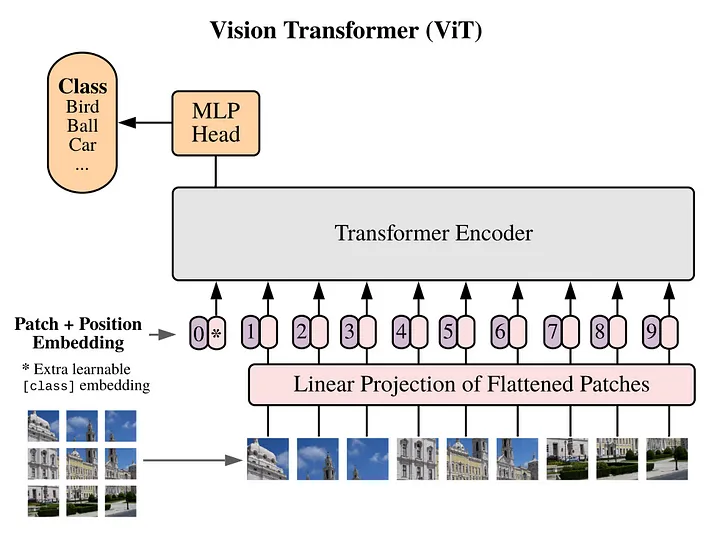

Import Libraries and Modules

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np

Patch Embeddings

In [2]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  # B: Batch Size
  # C: Image Channels
  # H: Image Height
  # W: Image Width
  # P_col: Patch Column
  # P_row: Patch Row
  def forward(self, x):
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)

    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)

    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)

    return x

Class Token and Positional Encoding

In [3]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()

    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, d_model)

    for pos in range(max_seq_length):
      for i in range(d_model):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Expand to have class token for every image in batch
    tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

    # Adding class tokens to the beginning of each embedding
    x = torch.cat((tokens_batch,x), dim=1)

    # Add positional encoding to embeddings
    x = x + self.pe

    return x

Attention Head

In [4]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

Multi-Head Attention

In [5]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    # Combine attention heads
    out = torch.cat([head(x) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

Transformer Encoder

In [6]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

Vision Transformer

In [7]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])

    # Classification MLP
    self.classifier = nn.Sequential(
        nn.Linear(self.d_model, self.n_classes),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:,0])

    return x

Training Parameters

In [8]:
d_model = 9
n_classes = 10
img_size = (32,32)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005

Loading MNIST Dataset

In [9]:
transform = T.Compose([
  T.Resize(img_size),
  T.ToTensor()
])

train_set = MNIST(
  root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
  root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.97MB/s]


Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):

  training_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = transformer(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    training_loss += loss.item()

  print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')

Using device:  cpu 
Epoch 1/5 loss: 1.738
Epoch 2/5 loss: 1.642
Epoch 3/5 loss: 1.628
Epoch 4/5 loss: 1.596
Epoch 5/5 loss: 1.554


Testing

In [11]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = transformer(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'\nModel Accuracy: {100 * correct // total} %')


Model Accuracy: 91 %
